Use this command to convert the notebook into a slideshow that can be presented:


 jupyter nbconvert --to slides --ServePostProcessor.port=8910 --ServePostProcessor.ip='0.0.0.0' --post serve /home/churtado/notebooks/churtado/smmt/SMMT.ipynb  
   
Access the slides here:  
http://10.13.12.209:8910/SMMT.slides.html#/

In [1]:
import plotly
plotly.tools.set_credentials_file(username='churtado', api_key='iaMRV6ydU9Ove5Yfy0R7')

In [2]:
%load_ext sparkmagic.magics

http://10.13.12.209:8998/

In [3]:
%manage_spark

MagicsControllerWidget(children=(Tab(children=(ManageSessionWidget(children=(HTML(value='<br/>'), HTML(value='…

Added endpoint http://10.13.12.209:8998/
Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
10,None,spark,idle,,,✔


SparkSession available as 'spark'.


In [4]:
%%spark
val sqlContext = new org.apache.spark.sql.hive.HiveContext(sc)

val df = sqlContext.read.format("com.crealytics.spark.excel").option("sheetName", "pc").option("useHeader", "true").option("inferSchema", "false").load("/user/hive/data/smmt/smmt.xls")
df.createTempView("pc")

sqlContext: org.apache.spark.sql.hive.HiveContext = org.apache.spark.sql.hive.HiveContext@1d01ce68
df: org.apache.spark.sql.DataFrame = [date: string, passenger_cars: string]


In [5]:
%%spark -c sql
SHOW TABLES

,database,tableName,isTemporary
0,default,cleaned_taxes,False
1,default,passenger_cars,False
2,,pc,True


In [6]:
%%spark -c sql
SELECT * from pc limit 3

,date,passenger_cars
0,2018-06-30,234945
1,2018-05-31,192649
2,2018-04-30,167911


In [7]:
%%spark -c sql
DROP TABLE IF EXISTS passenger_cars

""


In [8]:
%%spark -c sql 

CREATE TABLE passenger_cars AS
SELECT 
 date, 
 passenger_cars
FROM pc

""


In [9]:
%%spark -c sql -q -o df_passenger_cars
SELECT * from pc

This is an attempt to forecast SMMT passenger car data. 
  
The data consists of total PC sold, and date.

When decomposing a time series, there are 2 components to look out for:  
  
Systematic: Components of the time series that have consistency or recurrence and can be described and modeled.  
Non-Systematic: Components of the time series that cannot be directly modeled.  

Concretely, the components are:  
  
    Level: The average value in the series.  
    Trend: The increasing or decreasing value in the series.  
    Seasonality: The repeating short-term cycle in the series.  
    Noise: The random variation in the series.  

Let's try to decompose it. First set up our dataframe

In [10]:
%matplotlib inline

import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

df_passenger_cars_decomp = df_passenger_cars
df_passenger_cars_decomp['date'] = pd.to_datetime(df_passenger_cars_decomp['date'])
df_passenger_cars_decomp = df_passenger_cars_decomp.set_index('date')

In [11]:
df_passenger_cars_decomp.head(5)

,passenger_cars
date,
2018-06-30,234945
2018-05-31,192649
2018-04-30,167911
2018-03-31,474069
2018-02-28,80805


We're looking at this breakdown assuming an additive model first:

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_additive = seasonal_decompose(df_passenger_cars_decomp, model='additive')

We'll take the original values from our statsmodel decomp and plot them

In [38]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1_observed = go.Scatter(
    x = result_additive.observed.index,
    y = result_additive.observed.values,
    xaxis='x',
    yaxis='y',
    name='trend'
)
data_observed = [trace1_observed]
layout_observed = go.Layout(
    autosize=False,
    width=800,
    height=500,
    xaxis=dict(
        domain=[0, 1]
    ),
    yaxis=dict(
        domain=[0, 1]
    )


In [39]:
fig_data = go.Figure(data=data_observed, layout=layout_observed)
py.iplot(fig_data, filename='observed')

Neither the frequency nor the amplitude of the trend seem to increase or decrease over time.  
  
Overall trend seems linear.  
  
This would suggest that an additive model would be more appropriate for decomposition.

In [40]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1_additive = go.Scatter(
    x = result_additive.trend.index,
    y = result_additive.trend.values,
    xaxis='x3',
    yaxis='y3',
    name='trend'
)
trace2_additive = go.Scatter(
    x = result_additive.seasonal.index,
    y = result_additive.seasonal.values,
    xaxis='x2',
    yaxis='y2',
    name='seasonal'
)
trace3_additive = go.Scatter(
    x = result_additive.resid.index,
    y = result_additive.resid.values,
    xaxis='x',
    yaxis='y',
    name='residual'
)
trace4_additive = go.Scatter(
    x = result_additive.observed.index,
    y = result_additive.observed.values,
    xaxis='x4',
    yaxis='y4',
    name='observed'
)
data_additive = [trace4_additive, trace1_additive, trace2_additive, trace3_additive]
layout_additive = go.Layout(
    autosize=False,
    width=800,
    height=500,
    xaxis=dict(
        domain=[0, 1]
    ),
    yaxis=dict(
        domain=[0, 0.23]
    ),
    xaxis2=dict(
        domain=[0, 1],
        anchor='x2'
    ),
    yaxis2=dict(
        domain=[0.26, 0.48],
        anchor='y2'
    ),
    xaxis3=dict(
        domain=[0, 1],
        anchor='y3'
    ),
    yaxis3=dict(
        domain=[0.52, 0.73]
    ),
    xaxis4=dict(
        domain=[0, 1],
        anchor='y4'
    ),
    yaxis4=dict(
        domain=[0.76, 1],
        anchor='x4'
    )
)


We'll decompose the dataset using a naive decomposition first

In [41]:
fig_additive = go.Figure(data=data_additive, layout=layout_additive)
py.iplot(fig_additive, filename='additive-subplots')

Now we'll decompose using a naive multiplicative model

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_mult = seasonal_decompose(df_passenger_cars_decomp, model='multiplicative')

import plotly.plotly as py
import plotly.graph_objs as go

trace1_mult = go.Scatter(
    x = result_mult.trend.index,
    y = result_mult.trend.values,
    xaxis='x3',
    yaxis='y3',
    name='trend'
)
trace2_mult = go.Scatter(
    x = result_mult.seasonal.index,
    y = result_mult.seasonal.values,
    xaxis='x2',
    yaxis='y2',
    name='seasonal'
)
trace3_mult = go.Scatter(
    x = result_mult.resid.index,
    y = result_mult.resid.values,
    xaxis='x',
    yaxis='y',
    name='residual'
)
trace4_mult = go.Scatter(
    x = result_mult.observed.index,
    y = result_mult.observed.values,
    xaxis='x4',
    yaxis='y4',
    name='observed'
)
data_mult = [trace4_mult, trace1_mult, trace2_mult, trace3_mult]
layout_mult = go.Layout(
    autosize=False,
    width=800,
    height=500,
    xaxis=dict(
        domain=[0, 1]
    ),
    yaxis=dict(
        domain=[0, 0.23]
    ),
    xaxis2=dict(
        domain=[0, 1],
        anchor='x2'
    ),
    yaxis2=dict(
        domain=[0.26, 0.48],
        anchor='y2'
    ),
    xaxis3=dict(
        domain=[0, 1],
        anchor='y3'
    ),
    yaxis3=dict(
        domain=[0.52, 0.73]
    ),
    xaxis4=dict(
        domain=[0, 1],
        anchor='y4'
    ),
    yaxis4=dict(
        domain=[0.76, 1],
        anchor='x4'
    )
)

We've provided the multiplicative naive approach for reference. However, as mentioned before, an additive model may be more appropriate.

In [44]:
fig_mult = go.Figure(data=data_mult, layout=layout_mult)
py.iplot(fig_mult, filename='multiplicative-subplots')

Use of a naive model is generally discouraged. We'll now present STL decomposition (Seasonal and Trend decomposition using Loess)  
  
For more information see https://otexts.org/fpp2/stl.html  
The STL decomp package used is here: https://github.com/jrmontag/STLDecompose

STL decomp requires no missing values, so interpolation may be required. 

In [46]:
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)

In [54]:
stl = decompose(df_passenger_cars_decomp, period=12)

In [55]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1_stl = go.Scatter(
    x = stl.trend.index,
    y = stl.trend.values,
    xaxis='x3',
    yaxis='y3',
    name='trend'
)
trace2_stl = go.Scatter(
    x = stl.seasonal.index,
    y = stl.seasonal.values,
    xaxis='x2',
    yaxis='y2',
    name='seasonal'
)
trace3_stl = go.Scatter(
    x = stl.resid.index,
    y = stl.resid.values,
    xaxis='x',
    yaxis='y',
    name='residual'
)
trace4_stl = go.Scatter(
    x = stl.observed.index,
    y = stl.observed.values,
    xaxis='x4',
    yaxis='y4',
    name='observed'
)
data_stl = [trace4_stl, trace1_stl, trace2_stl, trace3_stl]
layout_stl = go.Layout(
    autosize=False,
    width=800,
    height=500,
    xaxis=dict(
        domain=[0, 1]
    ),
    yaxis=dict(
        domain=[0, 0.23]
    ),
    xaxis2=dict(
        domain=[0, 1],
        anchor='x2'
    ),
    yaxis2=dict(
        domain=[0.26, 0.48],
        anchor='y2'
    ),
    xaxis3=dict(
        domain=[0, 1],
        anchor='y3'
    ),
    yaxis3=dict(
        domain=[0.52, 0.73]
    ),
    xaxis4=dict(
        domain=[0, 1],
        anchor='y4'
    ),
    yaxis4=dict(
        domain=[0.76, 1],
        anchor='x4'
    )
)

In [56]:
fig_stl = go.Figure(data=data_stl, layout=layout_stl)
py.iplot(fig_stl, filename='stl-decomp')

We will now try to create an ARIMA model using this data to forecast PC numbers into the future.  
  
Taken from: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

    AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
    I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
    MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


The parameters of the ARIMA model are defined as follows:

    p: The number of lag observations included in the model, also called the lag order.
    d: The number of times that the raw observations are differenced, also called the degree of differencing.
    q: The size of the moving average window, also called the order of moving average.


Before we run the ARIMA model on the data, the series has to be transformed to become stationary.  

To put it in simpler terms, it has to have a constant mean and variance. And to be clear, stationarity is a property of a process, not a time series.

See here: https://en.wikipedia.org/wiki/Stationary_process  
See also: https://stats.stackexchange.com/questions/9951/intuitive-explanation-of-stationarity

There are several ways to test for stationarity, we'll apply a simple method.
  
What we'll do is split the series into 2, and calculate the mean and variance of each group of numbers and compare the values. It's a way of seeing if the avg and variance stay constant in the long run. 

The % differences seem to be small, but the ARIMA model failed for stationarity

In [79]:
from pandas import Series

series = df_passenger_cars_decomp
X = series.values
split = 33
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

In [81]:
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

print('meanDif_pct=%f, varDif_pct=%f' % ((mean1-mean2)/mean1, (var1-var2)/var1))

mean1=214667.090909, mean2=207213.878788
variance1=15697704021.719006, variance2=14433842867.924702
meanDif_pct=0.034720, varDif_pct=0.080512


We now have to use a technique for "de-meaning" or "de-variancing" it

Now, let's generate an autocorrelation plot

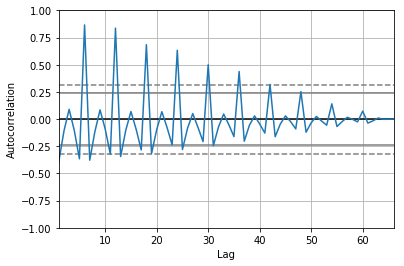

In [64]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_passenger_cars_decomp)
pyplot.show()

This is a good starting point for understanding autocorrelation plots:  
https://stats.stackexchange.com/questions/101467/how-to-interpret-autocorrelation
  
Quoting from the article:  
...Those plots are showing you the correlation of the series with itself, lagged by x time units. So imagine taking your time series of length T, copying it, and deleting the first observation of copy#1 and the last observation of copy#2. Now you have two series of length T−1 for which you calculate a correlation coefficient. This is the value of of the vertical axis at x=1 in your plots. It represents the correlation of the series lagged by one time unit. You go on and do this for all possible time lags x

and this defines the plot.

The answer to your question of what is needed to report a pattern is dependent on what pattern you would like to report. But quantitatively speaking, you have exactly what I just described: the correlation coefficient at different lags of the series. You can extract these numerical values by issuing the command...

The correlation coefficient is defined as:  
https://www.dummies.com/education/math/statistics/how-to-interpret-a-correlation-coefficient-r/

Based on the autocorrelation plot, a lag between 6-8 would be good for this dataset. It seems that there's a pattern that seems to repeat itself with that periodicity. We'll chose that as an initial lag value for ARIMA

In [71]:
from statsmodels.tsa.arima_model import ARIMA
 
# fit model with lag=6 (first param), difference order of 1 (second param) and moving avg model of 0 (3rd param)
# second param is to make the time series stationary
model = ARIMA(df_passenger_cars_decomp, order=(6,1,0))

# turn off debugging statements
#model_fit = model.fit(disp=0)

# let's see the result
#print(model_fit.summary())

# plot residual errors
#residuals = DataFrame(model_fit.resid)
#print(residuals.describe())

/home/churtado/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency -1M will be used.

/home/churtado/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency -1M will be used.



In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1_observed = go.Scatter(
    x = residuals.observed.index,
    y = result_additive.observed.values,
    xaxis='x',
    yaxis='y',
    name='trend'
)
data_observed = [trace1_observed]
layout_observed = go.Layout(
    autosize=False,
    width=800,
    height=500,
    xaxis=dict(
        domain=[0, 1]
    ),
    yaxis=dict(
        domain=[0, 1]
    )
